# Statistical Analysis & Validation
## Rigorous Testing of Update Decay Hypotheses

This notebook adds statistical rigor to validate findings from exploratory analysis.

## Section 1: Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, spearmanr, pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# Load data
df = pd.read_csv("../data/feature_engineered_monthly.csv")
df['year_month'] = pd.to_datetime(df['year_month'])
df_priority = pd.read_csv("../data/state_priority_classification_final.csv")

print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"States: {df['state'].nunique()}")
print(f"Time range: {df['year_month'].min()} to {df['year_month'].max()}")

Data loaded: 573 rows, 18 columns
States: 48
Time range: 2025-01-01 00:00:00 to 2025-12-01 00:00:00


## Section 2: Mann-Kendall Trend Test
### Statistical validation of decay trends

The Mann-Kendall test detects monotonic trends in time series data without assuming normality.

In [2]:
def mann_kendall_test(data):
    """
    Mann-Kendall trend test implementation.
    Returns: tau (trend strength), p_value, trend direction
    """
    n = len(data)
    if n < 3:
        return np.nan, np.nan, 'insufficient_data'
    
    # Calculate S statistic
    s = 0
    for i in range(n-1):
        for j in range(i+1, n):
            s += np.sign(data[j] - data[i])
    
    # Calculate variance
    var_s = n * (n - 1) * (2 * n + 5) / 18
    
    # Calculate Z statistic
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    
    # Calculate p-value (two-tailed)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    # Kendall's tau
    tau = s / (n * (n - 1) / 2)
    
    # Determine trend
    if p_value < 0.05:
        if tau > 0:
            trend = 'increasing'
        else:
            trend = 'decreasing'
    else:
        trend = 'no_trend'
    
    return tau, p_value, trend

print("Mann-Kendall test function defined")

Mann-Kendall test function defined


In [3]:
# Apply Mann-Kendall test to each state
trend_results = []

for state in df['state'].unique():
    state_data = df[df['state'] == state].sort_values('year_month')
    
    # Test update intensity trend
    tau, p_value, trend = mann_kendall_test(state_data['update_intensity'].values)
    
    trend_results.append({
        'state': state,
        'tau': tau,
        'p_value': p_value,
        'trend': trend,
        'statistically_significant': p_value < 0.05 if not np.isnan(p_value) else False,
        'avg_update_intensity': state_data['update_intensity'].mean(),
        'observations': len(state_data)
    })

df_trends = pd.DataFrame(trend_results)

# Display significant declining trends
declining = df_trends[
    (df_trends['trend'] == 'decreasing') & 
    (df_trends['statistically_significant'] == True)
].sort_values('tau')

print(f"\nStatistically Significant Declining Trends: {len(declining)}")
print("\nTop 10 States with Strongest Decay (by Kendall's Tau):")
print(declining[['state', 'tau', 'p_value', 'avg_update_intensity']].head(10))


Statistically Significant Declining Trends: 5

Top 10 States with Strongest Decay (by Kendall's Tau):
               state       tau   p_value  avg_update_intensity
6         CHANDIGARH -0.564103  0.008706            644.113815
17  HIMACHAL PRADESH -0.487179  0.023988            882.116229
36         RAJASTHAN -0.487179  0.023988             58.108585
32            ORISSA -0.461538  0.032736            266.868794
29           MIZORAM -0.435897  0.044084             64.005837


## Section 3: Correlation Analysis
### Understanding relationships between metrics

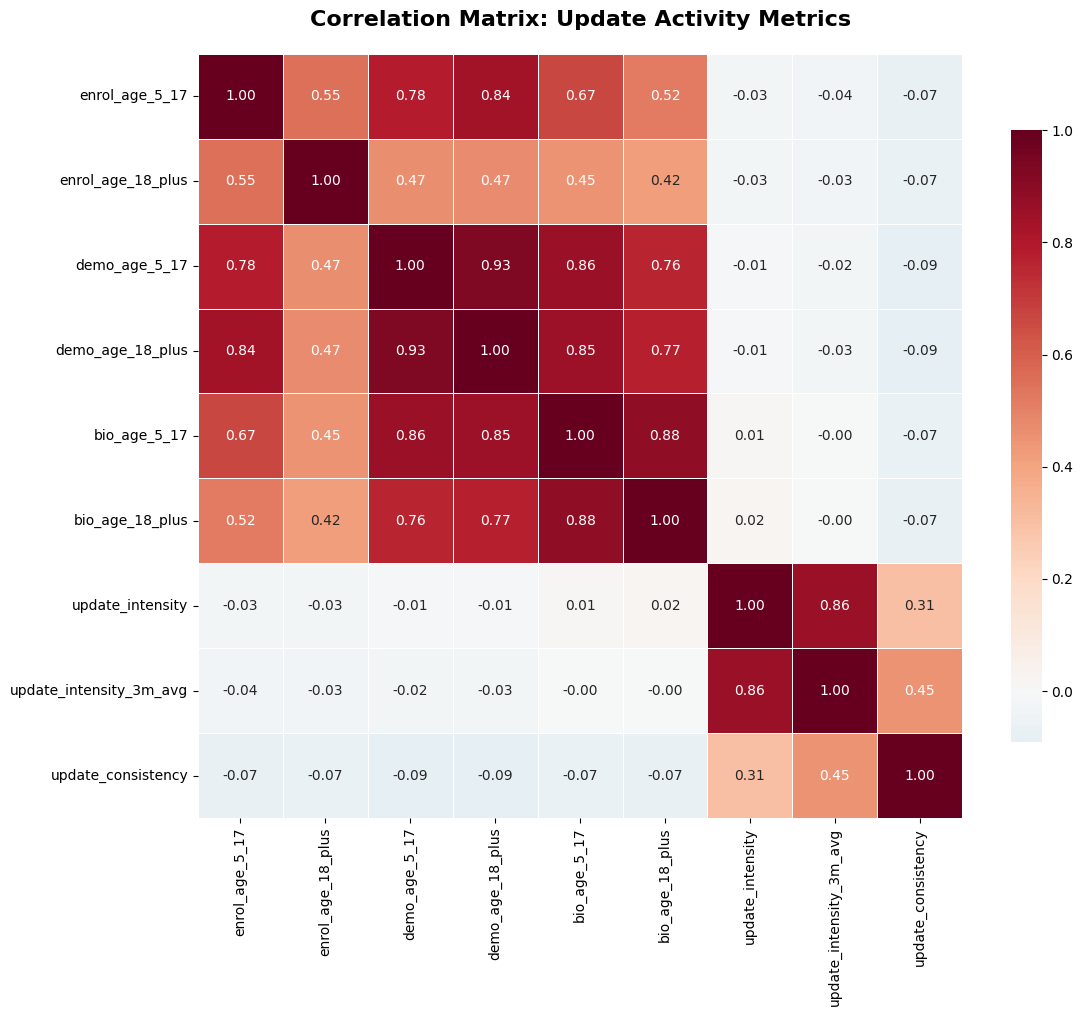

Correlation matrix saved to: ../data/correlation_heatmap.png


In [4]:
# Select numeric columns for correlation analysis
numeric_cols = [
    'enrol_age_5_17', 'enrol_age_18_plus',
    'demo_age_5_17', 'demo_age_18_plus',
    'bio_age_5_17', 'bio_age_18_plus',
    'update_intensity', 'update_intensity_3m_avg',
    'update_consistency'
]

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='RdBu_r', 
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Correlation Matrix: Update Activity Metrics', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../data/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation matrix saved to: ../data/correlation_heatmap.png")

In [5]:
# Find strongest correlations with update_intensity
intensity_corr = corr_matrix['update_intensity'].sort_values(ascending=False)

print("\nStrongest Correlations with Update Intensity:")
print(intensity_corr)


Strongest Correlations with Update Intensity:
update_intensity           1.000000
update_intensity_3m_avg    0.862663
update_consistency         0.305025
bio_age_18_plus            0.016727
bio_age_5_17               0.013079
demo_age_5_17             -0.007641
demo_age_18_plus          -0.012281
enrol_age_18_plus         -0.025955
enrol_age_5_17            -0.029447
Name: update_intensity, dtype: float64


## Section 4: State Benchmarking
### Percentile rankings and national comparison

In [6]:
# Calculate state-level aggregates - FIXED COLUMN NAME
state_summary = df.groupby('state').agg({
    'update_intensity': ['mean', 'std', 'min', 'max'],
    'update_intensity_3m_avg': 'last',
    'total_updates': 'sum',
    'total_enrolment': 'sum'  # FIXED: was 'total_enrolments'
}).reset_index()

state_summary.columns = ['state', 'avg_intensity', 'std_intensity', 'min_intensity', 
                          'max_intensity', 'recent_intensity', 'total_updates', 'total_enrolment']

# Calculate percentiles
state_summary['percentile'] = state_summary['avg_intensity'].rank(pct=True) * 100

# National statistics
national_median = state_summary['avg_intensity'].median()
national_mean = state_summary['avg_intensity'].mean()

# Flag states below median
state_summary['below_median'] = state_summary['avg_intensity'] < national_median

# Merge with trend data
state_summary = state_summary.merge(df_trends[['state', 'tau', 'p_value', 'trend']], on='state', how='left')

print(f"National Median Update Intensity: {national_median:.4f}")
print(f"National Mean Update Intensity: {national_mean:.4f}")
print(f"\nStates below national median: {state_summary['below_median'].sum()}")

# Bottom 10 performers
print("\nBottom 10 Performers (Lowest Average Update Intensity):")
bottom_10 = state_summary.nsmallest(10, 'avg_intensity')[[
    'state', 'avg_intensity', 'percentile', 'trend', 'total_updates'
]]
print(bottom_10)

# Save benchmarking results
state_summary.to_csv('../data/state_benchmarking.csv', index=False)
print("\nBenchmarking data saved to: ../data/state_benchmarking.csv")

National Median Update Intensity: 117.0840
National Mean Update Intensity: 249.0501

States below national median: 24

Bottom 10 Performers (Lowest Average Update Intensity):
                                           state  avg_intensity  percentile              trend  total_updates
40  THE DADRA AND NAGAR HAVELI AND DAMAN AND DIU       0.000000    2.083333  insufficient_data            0.0
44                                  WEST  BENGAL       5.500000    4.166667           no_trend          114.0
28                                     MEGHALAYA       5.749409    6.250000           no_trend       175004.0
47                                    WESTBENGAL      13.750000    8.333333           no_trend          109.0
45                                   WEST BANGAL      17.500000   10.416667           no_trend          117.0
30                                      NAGALAND      20.573179   12.500000           no_trend       146384.0
18                               JAMMU & KASHMIR      2

## Section 5: Confidence Intervals
### Quantifying uncertainty in metrics

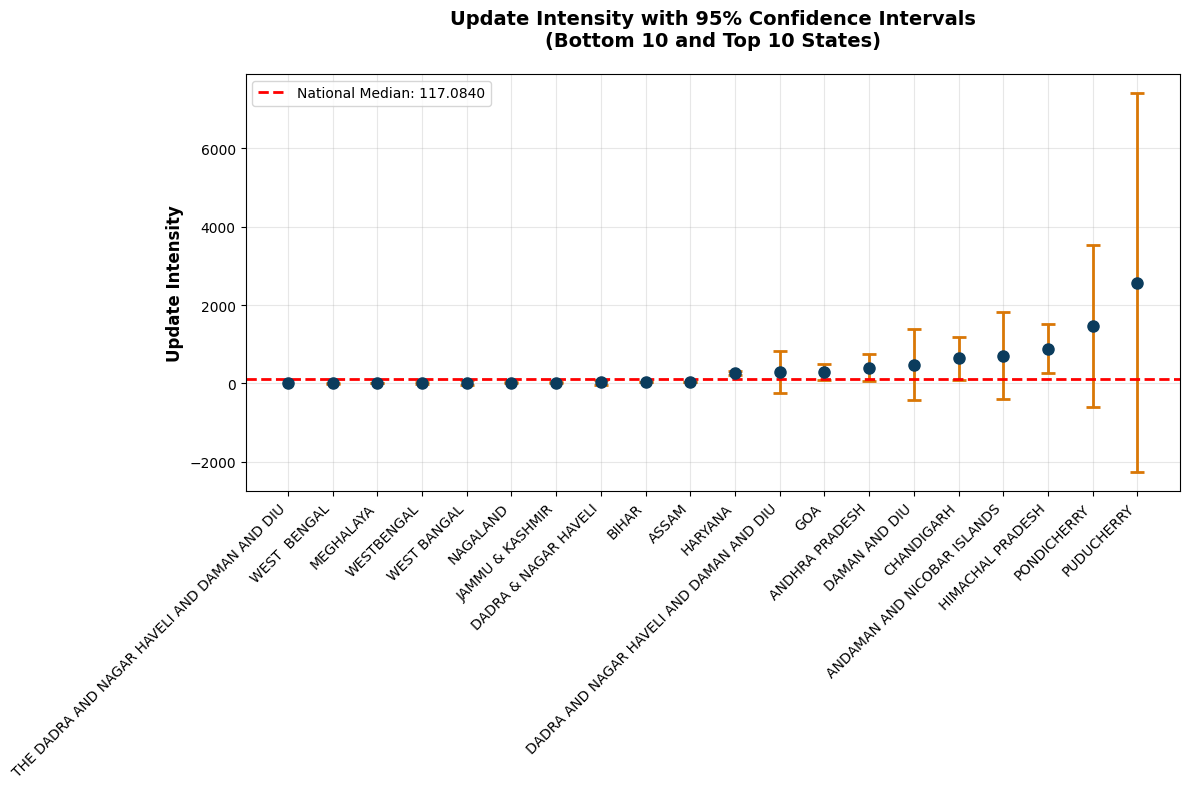

Confidence interval plot saved to: ../data/confidence_intervals.png


In [7]:
def calculate_ci(data, confidence=0.95):
    """
    Calculate confidence interval for mean.
    """
    n = len(data)
    if n < 2:
        return np.nan, np.nan
    
    mean = np.mean(data)
    std_err = stats.sem(data)
    margin = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    
    return mean - margin, mean + margin

# Calculate CI for each state
ci_results = []

for state in df['state'].unique():
    state_data = df[df['state'] == state]['update_intensity'].values
    
    mean_val = np.mean(state_data)
    ci_lower, ci_upper = calculate_ci(state_data)
    
    ci_results.append({
        'state': state,
        'mean': mean_val,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'ci_width': ci_upper - ci_lower
    })

df_ci = pd.DataFrame(ci_results).sort_values('mean')

# Visualize top and bottom states with CI
combined = pd.concat([df_ci.head(10), df_ci.tail(10)])

plt.figure(figsize=(12, 8))
plt.errorbar(
    range(len(combined)),
    combined['mean'],
    yerr=[combined['mean'] - combined['ci_lower'], combined['ci_upper'] - combined['mean']],
    fmt='o',
    capsize=5,
    capthick=2,
    markersize=8,
    color='#0B3C5D',
    ecolor='#D97706',
    elinewidth=2
)
plt.axhline(y=national_median, color='red', linestyle='--', label=f'National Median: {national_median:.4f}', linewidth=2)
plt.xticks(range(len(combined)), combined['state'].values, rotation=45, ha='right')
plt.ylabel('Update Intensity', fontsize=12, fontweight='bold')
plt.title('Update Intensity with 95% Confidence Intervals\n(Bottom 10 and Top 10 States)', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../data/confidence_intervals.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confidence interval plot saved to: ../data/confidence_intervals.png")

## Section 6: Effect Size Analysis
### Quantifying magnitude of decay

In [8]:
# Calculate effect size (Cohen's d) for decay
# Comparing first 3 months vs last 3 months

effect_sizes = []

for state in df['state'].unique():
    state_data = df[df['state'] == state].sort_values('year_month')
    
    if len(state_data) < 6:
        continue
    
    # First 3 months
    early = state_data.head(3)['update_intensity'].values
    # Last 3 months
    recent = state_data.tail(3)['update_intensity'].values
    
    # Calculate Cohen's d
    mean_early = np.mean(early)
    mean_recent = np.mean(recent)
    
    pooled_std = np.sqrt((np.var(early) + np.var(recent)) / 2)
    
    if pooled_std > 0:
        cohens_d = (mean_recent - mean_early) / pooled_std
    else:
        cohens_d = 0
    
    # Interpret effect size
    if abs(cohens_d) < 0.2:
        magnitude = 'negligible'
    elif abs(cohens_d) < 0.5:
        magnitude = 'small'
    elif abs(cohens_d) < 0.8:
        magnitude = 'medium'
    else:
        magnitude = 'large'
    
    effect_sizes.append({
        'state': state,
        'early_mean': mean_early,
        'recent_mean': mean_recent,
        'change': mean_recent - mean_early,
        'cohens_d': cohens_d,
        'magnitude': magnitude
    })

df_effect = pd.DataFrame(effect_sizes).sort_values('cohens_d')

# States with large negative effect (strong decay)
strong_decay = df_effect[df_effect['cohens_d'] < -0.8]

print(f"\nStates with LARGE effect size decay: {len(strong_decay)}")
print("\nTop 10 States with Strongest Decay (by Effect Size):")
print(df_effect.head(10)[['state', 'early_mean', 'recent_mean', 'change', 'cohens_d', 'magnitude']])

# Save effect size analysis
df_effect.to_csv('../data/effect_size_analysis.csv', index=False)
print("\nEffect size analysis saved to: ../data/effect_size_analysis.csv")


States with LARGE effect size decay: 28

Top 10 States with Strongest Decay (by Effect Size):
                          state   early_mean  recent_mean       change  cohens_d magnitude
3             ARUNACHAL PRADESH    71.335102    38.375105   -32.959997 -1.677365     large
28                      MIZORAM    88.413270    40.202942   -48.210328 -1.498045     large
6                    CHANDIGARH  1659.252525   253.313158 -1405.939367 -1.493709     large
15                      HARYANA   330.877487   228.145159  -102.732328 -1.370994     large
41                  UTTARAKHAND   331.662004   193.551551  -138.110452 -1.273778     large
1   ANDAMAN AND NICOBAR ISLANDS  2665.000000   112.372549 -2552.627451 -1.249066     large
5                         BIHAR    34.899852    26.519676    -8.380176 -1.224289     large
16             HIMACHAL PRADESH  1923.168785   475.722042 -1447.446743 -1.224001     large
19                    JHARKHAND    97.838682    37.354153   -60.484529 -1.168432     l

## Section 7: Summary Statistics
### Key findings for reporting

In [9]:
# Generate summary report
summary_stats = {
    'total_states': df['state'].nunique(),
    'total_observations': len(df),
    'states_with_significant_decline': len(df_trends[df_trends['trend'] == 'decreasing']),
    'states_with_large_effect_decay': len(df_effect[df_effect['cohens_d'] < -0.8]),
    'states_below_median': state_summary['below_median'].sum(),
    'national_median_intensity': national_median,
    'national_mean_intensity': national_mean,
    'lowest_intensity_state': state_summary.nsmallest(1, 'avg_intensity')['state'].values[0],
    'lowest_intensity_value': state_summary['avg_intensity'].min(),
    'highest_intensity_state': state_summary.nlargest(1, 'avg_intensity')['state'].values[0],
    'highest_intensity_value': state_summary['avg_intensity'].max()
}

print("\n" + "="*60)
print("STATISTICAL ANALYSIS SUMMARY")
print("="*60)
for key, value in summary_stats.items():
    print(f"{key.replace('_', ' ').title()}: {value}")
print("="*60)

# Save summary
pd.DataFrame([summary_stats]).to_csv('../data/statistical_summary.csv', index=False)
print("\nSummary saved to: ../data/statistical_summary.csv")


STATISTICAL ANALYSIS SUMMARY
Total States: 48
Total Observations: 573
States With Significant Decline: 5
States With Large Effect Decay: 28
States Below Median: 24
National Median Intensity: 117.08400467562507
National Mean Intensity: 249.05014362292184
Lowest Intensity State: THE DADRA AND NAGAR HAVELI AND DAMAN AND DIU
Lowest Intensity Value: 0.0
Highest Intensity State: PUDUCHERRY
Highest Intensity Value: 2573.5876089427816

Summary saved to: ../data/statistical_summary.csv
